In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from time import time
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
pd.options.display.max_columns = None
pd.options.display.max_rows = None
matplotlib.rcParams.update({'font.size': 22})
from pytz import timezone as tz
import gluonts

In [2]:
data_path = "./data/"
data_freq = "H"
patience = 10
learning_rate = 0.0001

start_train_date = datetime(2017, 1, 1)
end_train_date = datetime(2018, 12, 31)
test_date = datetime(2019, 1, 1)
nb_hours_pred = 2*7*24

In [3]:
df = pd.read_csv(data_path + "eco2mix-regional-cons-def.csv", sep=";",
                parse_dates=["Date - Heure"],
                usecols=["Région", "Date - Heure", "Consommation (MW)"]).sort_values(
    by=["Région", "Date - Heure"])

In [4]:
df.rename(columns={"Date - Heure": "Date"}, inplace=True)
df.fillna(df.dropna()["Consommation (MW)"].mean(), inplace=True)
df["date_heure"] = df["Date"].apply(lambda x: x + timedelta(minutes=x.minute))
df["date_heure"] = df["date_heure"].apply(lambda x: x.astimezone(tz("UTC")))
df["date_heure"] = df["date_heure"].apply(lambda x: x.fromtimestamp(x.timestamp()))
df.head(3)

,Région,Date,Consommation (MW),date_heure
1288256,Auvergne-Rhône-Alpes,2013-01-01 00:00:00+01:00,4528.493194,2013-01-01 00:00:00
1288257,Auvergne-Rhône-Alpes,2013-01-01 00:30:00+01:00,8173.000000,2013-01-01 01:00:00
116935,Auvergne-Rhône-Alpes,2013-01-01 01:00:00+01:00,7944.000000,2013-01-01 01:00:00


In [5]:
df_hour = df.groupby(["Région", "date_heure"], as_index=False).agg({"Consommation (MW)": np.sum})
df_hour.head(3)

,Région,date_heure,Consommation (MW)
0,Auvergne-Rhône-Alpes,2013-01-01 00:00:00,4528.493194
1,Auvergne-Rhône-Alpes,2013-01-01 01:00:00,16117.000000
2,Auvergne-Rhône-Alpes,2013-01-01 02:00:00,15778.000000


In [6]:
df_dict = {}

for region in pd.unique(df_hour["Région"]):
    df_dict[region] = df_hour[df_hour["Région"]==region].copy().reset_index(drop=True)
    df_dict[region].index = df_dict[region]["date_heure"]
    df_dict[region] = df_dict[region].reindex(
        pd.date_range(start=df_hour["date_heure"].min(), end=df_hour["date_heure"].max(), freq=data_freq)).drop(
        ["date_heure", "Région"], axis=1)

# Fonctions pour entraînement DeepAR

In [7]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions

def train_predictor(df_dict, end_train_date, regions_list, target_col, max_epochs, feat_dynamic_cols=None):
    estimator = DeepAREstimator(freq=data_freq, 
                                prediction_length=nb_hours_pred,
                                trainer=Trainer(epochs=max_epochs, learning_rate = learning_rate,
                                                learning_rate_decay_factor=0.01, patience=patience),
                                use_feat_dynamic_real=feat_dynamic_cols is not None)
    if feat_dynamic_cols is not None:
        
        training_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region][target_col][:end_train_date],
             "feat_dynamic_real": [df_dict[region][feat_dynamic_col][:end_train_date]
                                   for feat_dynamic_col in feat_dynamic_cols] 
             }
            for region in regions_list],
            freq = data_freq
        )
    else:
        training_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region][target_col][:end_train_date]
             }
            for region in regions_list],
            freq = data_freq
        )

    predictor = estimator.train(training_data=training_data)
    
    return predictor


def make_predictions(predictor, df_dict, test_date, regions_list, target_col, feat_dynamic_cols=None):
    if feat_dynamic_cols is not None:
        test_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region][target_col][:test_date + timedelta(hours=nb_hours_pred)],
             "feat_dynamic_real": [df_dict[region][feat_dynamic_col][:test_date + timedelta(hours=nb_hours_pred)]
                                   for feat_dynamic_col in feat_dynamic_cols]
             }
            for region in regions_list],
            freq = data_freq
            )
    else:
         test_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region][target_col][:test_date + timedelta(hours=nb_hours_pred)],
             }
            for region in regions_list],
            freq = data_freq
            )

    forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_eval_samples=100)
    
    return list(forecast_it), list(ts_it)


def plot_forecasts(df_dict, test_date, tss, forecasts, past_length, num_plots, figname):
    label_fontsize = 16
    for target, forecast in zip(tss, forecasts):
        ax = target[-past_length:].plot(figsize=(20, 8), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        
        results_mean = forecast.mean
        ground_truth = df_dict[forecast.item_id]["Consommation (MW)"][
            test_date + timedelta(hours=1):test_date + timedelta(hours=nb_hours_pred)].values
        MAPE = np.mean(np.apply_along_axis(abs, 0, (ground_truth - results_mean) / ground_truth))
        plt.title(forecast.item_id + " MAPE:{}%".format(str(round(100*MAPE, 1))))
        plt.ylabel("Consumption (MW)")
        plt.xlabel("")
        ax.set_xlim([test_date - timedelta(days=nb_hours_pred/24), test_date + timedelta(days=nb_hours_pred/24)])
        ax.set_ylim([12000, 28000])
        xticks = [test_date + timedelta(days=x) for x in [-11, -7, -3, 0, 4, 8, 12]]
        ax.set_xticks(xticks, minor=True)
        ax.set_xticklabels([datetime.strftime(date, "%Y-%m-%d") for date in xticks if date != test_date],
                           minor=True, fontsize=label_fontsize)
        ax.set_xticklabels(["", datetime.strftime(test_date, "%Y-%m-%d"), ""], minor=False,
                           fontsize=label_fontsize)
        yticks = np.arange(14000, 28000, step=2000)
        ax.set_yticks(yticks)
        ax.set_yticklabels([str(x) for x in yticks], fontsize=label_fontsize)
        plt.savefig(figname)
        plt.show()
    
    return MAPE

INFO:root:Using CPU


# Test Île de France

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it, avg_epoch_loss=10.4]
INFO:root:Epoch[0] Elapsed time 59.726 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.365293
INFO:root:Epoch[1] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.01s/it, avg_epoch_loss=9.47]
INFO:root:Epoch[1] Elapsed time 50.662 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.469528
INFO:root:Epoch[2] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.01s/it, avg_epoch_loss=9.07]
INFO:root:Epoch[2] Elapsed time 50.360 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=9.067757
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████████████████████████

INFO:root:Epoch[30] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.02s/it, avg_epoch_loss=7.34]
INFO:root:Epoch[30] Elapsed time 51.117 seconds
INFO:root:Epoch[30] Evaluation metric 'epoch_loss'=7.342621
INFO:root:Epoch[31] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.01s/it, avg_epoch_loss=7.33]
INFO:root:Epoch[31] Elapsed time 50.301 seconds
INFO:root:Epoch[31] Evaluation metric 'epoch_loss'=7.327215
INFO:root:Epoch[32] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.04s/it, avg_epoch_loss=7.31]
INFO:root:Epoch[32] Elapsed time 51.792 seconds
INFO:root:Epoch[32] Evaluation metric 'epoch_loss'=7.309674
INFO:root:Epoch[33] Learning rate is 0.0001
100%|██████████████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.01s/it, avg_epoch_loss=7.3]
INFO:root:Epoch[33] 

100%|█████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.06s/it, avg_epoch_loss=7.03]
INFO:root:Epoch[60] Elapsed time 53.023 seconds
INFO:root:Epoch[60] Evaluation metric 'epoch_loss'=7.027170
INFO:root:Epoch[61] Learning rate is 0.0001
100%|████████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.05s/it, avg_epoch_loss=7]
INFO:root:Epoch[61] Elapsed time 52.435 seconds
INFO:root:Epoch[61] Evaluation metric 'epoch_loss'=6.995710
INFO:root:Epoch[62] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.06s/it, avg_epoch_loss=7.02]
INFO:root:Epoch[62] Elapsed time 52.941 seconds
INFO:root:Epoch[62] Evaluation metric 'epoch_loss'=7.019350
INFO:root:Epoch[63] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it, avg_epoch_loss=7.02]
INFO:root:Epoch[63] Elapsed time 53.271 seconds
INFO:root:Epoch[

100%|█████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it, avg_epoch_loss=6.91]
INFO:root:Epoch[90] Elapsed time 53.353 seconds
INFO:root:Epoch[90] Evaluation metric 'epoch_loss'=6.912065
INFO:root:Epoch[91] Learning rate is 0.0001
100%|██████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.06s/it, avg_epoch_loss=6.9]
INFO:root:Epoch[91] Elapsed time 52.962 seconds
INFO:root:Epoch[91] Evaluation metric 'epoch_loss'=6.896190
INFO:root:Epoch[92] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.06s/it, avg_epoch_loss=6.88]
INFO:root:Epoch[92] Elapsed time 53.195 seconds
INFO:root:Epoch[92] Evaluation metric 'epoch_loss'=6.878819
INFO:root:Epoch[93] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.05s/it, avg_epoch_loss=6.89]
INFO:root:Epoch[93] Elapsed time 52.535 seconds
INFO:root:Epoch[

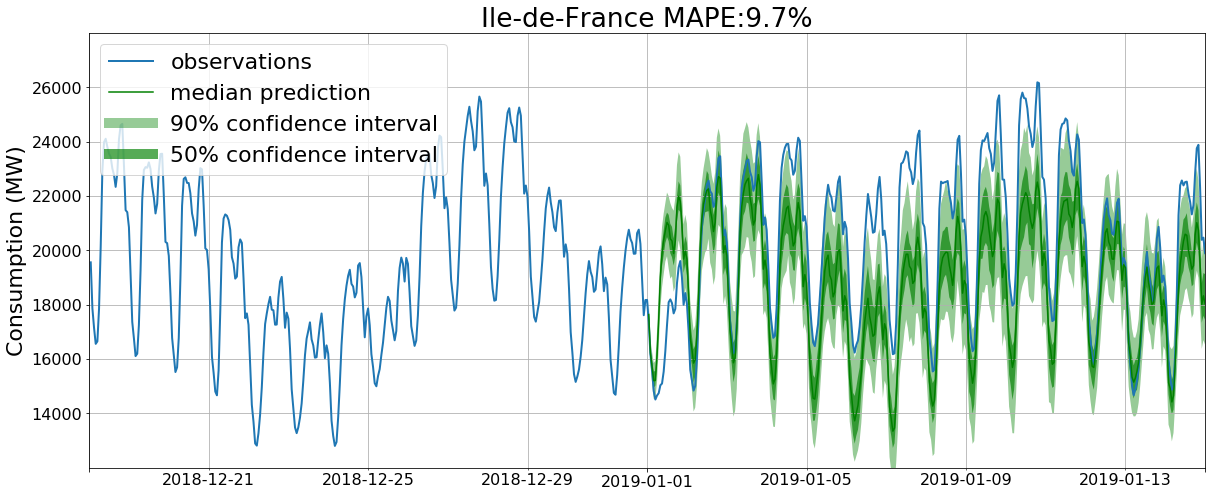

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.23s/it, avg_epoch_loss=10.7]
INFO:root:Epoch[0] Elapsed time 61.532 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.741959
INFO:root:Epoch[1] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it, avg_epoch_loss=9.73]
INFO:root:Epoch[1] Elapsed time 54.197 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.728044
INFO:root:Epoch[2] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it, avg_epoch_loss=9.11]
INFO:root:Epoch[2] Elapsed time 60.615 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=9.105769
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████████████████████████

INFO:root:Epoch[30] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it, avg_epoch_loss=7.34]
INFO:root:Epoch[30] Elapsed time 53.702 seconds
INFO:root:Epoch[30] Evaluation metric 'epoch_loss'=7.339860
INFO:root:Epoch[31] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it, avg_epoch_loss=7.32]
INFO:root:Epoch[31] Elapsed time 53.415 seconds
INFO:root:Epoch[31] Evaluation metric 'epoch_loss'=7.315008
INFO:root:Epoch[32] Learning rate is 0.0001
100%|██████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.04s/it, avg_epoch_loss=7.3]
INFO:root:Epoch[32] Elapsed time 52.093 seconds
INFO:root:Epoch[32] Evaluation metric 'epoch_loss'=7.297182
INFO:root:Epoch[33] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.03s/it, avg_epoch_loss=7.27]
INFO:root:Epoch[33] 

100%|█████████████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.02s/it, avg_epoch_loss=6.97]
INFO:root:Epoch[60] Elapsed time 51.218 seconds
INFO:root:Epoch[60] Evaluation metric 'epoch_loss'=6.969045
INFO:root:Epoch[61] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.02s/it, avg_epoch_loss=6.95]
INFO:root:Epoch[61] Elapsed time 51.170 seconds
INFO:root:Epoch[61] Evaluation metric 'epoch_loss'=6.948415
INFO:root:Epoch[62] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.04s/it, avg_epoch_loss=6.94]
INFO:root:Epoch[62] Elapsed time 51.897 seconds
INFO:root:Epoch[62] Evaluation metric 'epoch_loss'=6.943586
INFO:root:Epoch[63] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.03s/it, avg_epoch_loss=6.95]
INFO:root:Epoch[63] Elapsed time 51.595 seconds
INFO:root:Epoch[

100%|█████████████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.02s/it, avg_epoch_loss=6.82]
INFO:root:Epoch[90] Elapsed time 51.089 seconds
INFO:root:Epoch[90] Evaluation metric 'epoch_loss'=6.822189
INFO:root:Epoch[91] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.02s/it, avg_epoch_loss=6.83]
INFO:root:Epoch[91] Elapsed time 51.209 seconds
INFO:root:Epoch[91] Evaluation metric 'epoch_loss'=6.828950
INFO:root:Epoch[92] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.03s/it, avg_epoch_loss=6.83]
INFO:root:Epoch[92] Elapsed time 51.693 seconds
INFO:root:Epoch[92] Evaluation metric 'epoch_loss'=6.829522
INFO:root:Epoch[93] Learning rate is 0.0001
100%|██████████████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.02s/it, avg_epoch_loss=6.8]
INFO:root:Epoch[93] Elapsed time 50.914 seconds
INFO:root:Epoch[

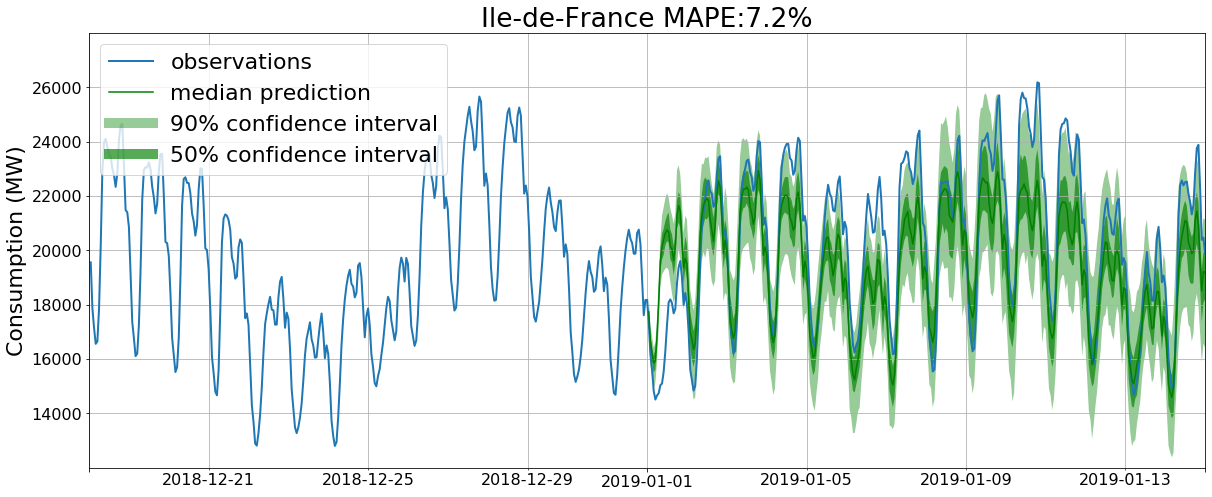

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|███████████████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.16s/it, avg_epoch_loss=12]
INFO:root:Epoch[0] Elapsed time 57.894 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=12.040506
INFO:root:Epoch[1] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.03s/it, avg_epoch_loss=9.96]
INFO:root:Epoch[1] Elapsed time 51.636 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.955467
INFO:root:Epoch[2] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.02s/it, avg_epoch_loss=9.26]
INFO:root:Epoch[2] Elapsed time 51.188 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=9.258179
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████████████████████████

INFO:root:Epoch[30] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.05s/it, avg_epoch_loss=7.35]
INFO:root:Epoch[30] Elapsed time 52.437 seconds
INFO:root:Epoch[30] Evaluation metric 'epoch_loss'=7.349247
INFO:root:Epoch[31] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.03s/it, avg_epoch_loss=7.33]
INFO:root:Epoch[31] Elapsed time 51.643 seconds
INFO:root:Epoch[31] Evaluation metric 'epoch_loss'=7.326844
INFO:root:Epoch[32] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.05s/it, avg_epoch_loss=7.31]
INFO:root:Epoch[32] Elapsed time 52.409 seconds
INFO:root:Epoch[32] Evaluation metric 'epoch_loss'=7.306921
INFO:root:Epoch[33] Learning rate is 0.0001
100%|██████████████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.04s/it, avg_epoch_loss=7.3]
INFO:root:Epoch[33] 

100%|█████████████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it, avg_epoch_loss=7.09]
INFO:root:Epoch[60] Elapsed time 59.449 seconds
INFO:root:Epoch[60] Evaluation metric 'epoch_loss'=7.085322
INFO:root:Epoch[61] Learning rate is 0.0001
100%|██████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it, avg_epoch_loss=7.1]
INFO:root:Epoch[61] Elapsed time 53.813 seconds
INFO:root:Epoch[61] Evaluation metric 'epoch_loss'=7.097230
INFO:root:Epoch[62] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it, avg_epoch_loss=7.08]
INFO:root:Epoch[62] Elapsed time 53.460 seconds
INFO:root:Epoch[62] Evaluation metric 'epoch_loss'=7.078524
INFO:root:Epoch[63] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it, avg_epoch_loss=7.08]
INFO:root:Epoch[63] Elapsed time 54.372 seconds
INFO:root:Epoch[

100%|█████████████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.10s/it, avg_epoch_loss=6.94]
INFO:root:Epoch[90] Elapsed time 54.843 seconds
INFO:root:Epoch[90] Evaluation metric 'epoch_loss'=6.943438
INFO:root:Epoch[91] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.14s/it, avg_epoch_loss=6.95]
INFO:root:Epoch[91] Elapsed time 56.916 seconds
INFO:root:Epoch[91] Evaluation metric 'epoch_loss'=6.951083
INFO:root:Epoch[92] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.13s/it, avg_epoch_loss=6.94]
INFO:root:Epoch[92] Elapsed time 56.455 seconds
INFO:root:Epoch[92] Evaluation metric 'epoch_loss'=6.939712
INFO:root:Epoch[93] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it, avg_epoch_loss=6.96]
INFO:root:Epoch[93] Elapsed time 53.974 seconds
INFO:root:Epoch[

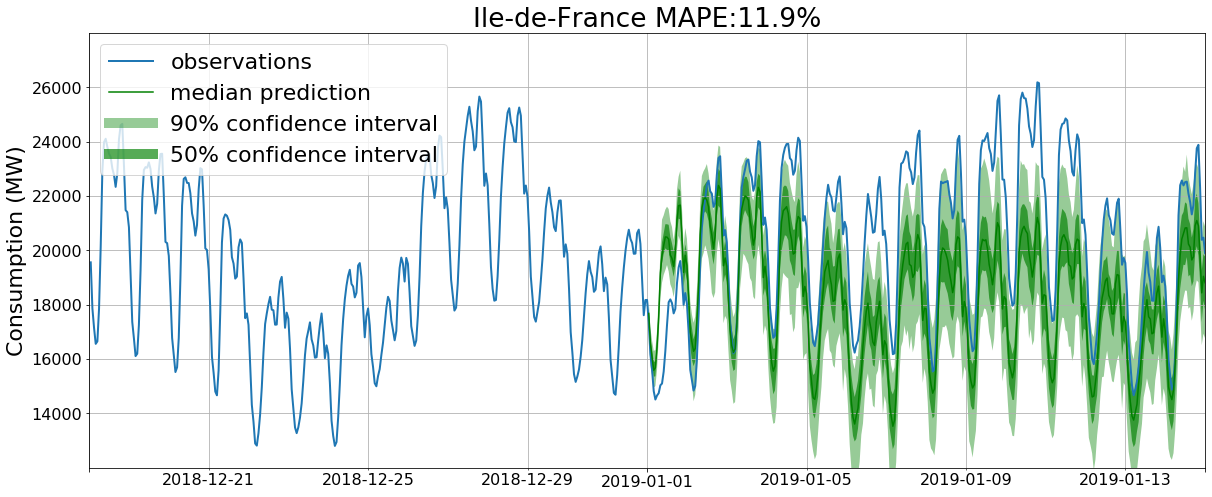

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.23s/it, avg_epoch_loss=9.79]
INFO:root:Epoch[0] Elapsed time 61.630 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=9.785185
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it, avg_epoch_loss=9.1]
INFO:root:Epoch[1] Elapsed time 53.882 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.095670
INFO:root:Epoch[2] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.17s/it, avg_epoch_loss=8.85]
INFO:root:Epoch[2] Elapsed time 58.351 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=8.848914
INFO:root:Epoch[3] Learning rate is 0.0001
100%|███████████████████████████████

INFO:root:Epoch[30] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it, avg_epoch_loss=7.37]
INFO:root:Epoch[30] Elapsed time 54.141 seconds
INFO:root:Epoch[30] Evaluation metric 'epoch_loss'=7.369143
INFO:root:Epoch[31] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it, avg_epoch_loss=7.35]
INFO:root:Epoch[31] Elapsed time 53.808 seconds
INFO:root:Epoch[31] Evaluation metric 'epoch_loss'=7.351818
INFO:root:Epoch[32] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it, avg_epoch_loss=7.34]
INFO:root:Epoch[32] Elapsed time 53.760 seconds
INFO:root:Epoch[32] Evaluation metric 'epoch_loss'=7.335147
INFO:root:Epoch[33] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it, avg_epoch_loss=7.32]
INFO:root:Epoch[33] 

100%|██████████████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.11s/it, avg_epoch_loss=7.1]
INFO:root:Epoch[60] Elapsed time 55.433 seconds
INFO:root:Epoch[60] Evaluation metric 'epoch_loss'=7.099494
INFO:root:Epoch[61] Learning rate is 0.0001
100%|██████████████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.11s/it, avg_epoch_loss=7.1]
INFO:root:Epoch[61] Elapsed time 55.329 seconds
INFO:root:Epoch[61] Evaluation metric 'epoch_loss'=7.103247
INFO:root:Epoch[62] Learning rate is 0.0001
100%|██████████████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.13s/it, avg_epoch_loss=7.1]
INFO:root:Epoch[62] Elapsed time 56.586 seconds
INFO:root:Epoch[62] Evaluation metric 'epoch_loss'=7.098247
INFO:root:Epoch[63] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.10s/it, avg_epoch_loss=7.08]
INFO:root:Epoch[63] Elapsed time 54.969 seconds
INFO:root:Epoch[

100%|█████████████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it, avg_epoch_loss=6.97]
INFO:root:Epoch[90] Elapsed time 54.336 seconds
INFO:root:Epoch[90] Evaluation metric 'epoch_loss'=6.971849
INFO:root:Epoch[91] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it, avg_epoch_loss=6.96]
INFO:root:Epoch[91] Elapsed time 54.206 seconds
INFO:root:Epoch[91] Evaluation metric 'epoch_loss'=6.964508
INFO:root:Epoch[92] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.10s/it, avg_epoch_loss=6.96]
INFO:root:Epoch[92] Elapsed time 55.054 seconds
INFO:root:Epoch[92] Evaluation metric 'epoch_loss'=6.957093
INFO:root:Epoch[93] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it, avg_epoch_loss=6.97]
INFO:root:Epoch[93] Elapsed time 54.269 seconds
INFO:root:Epoch[

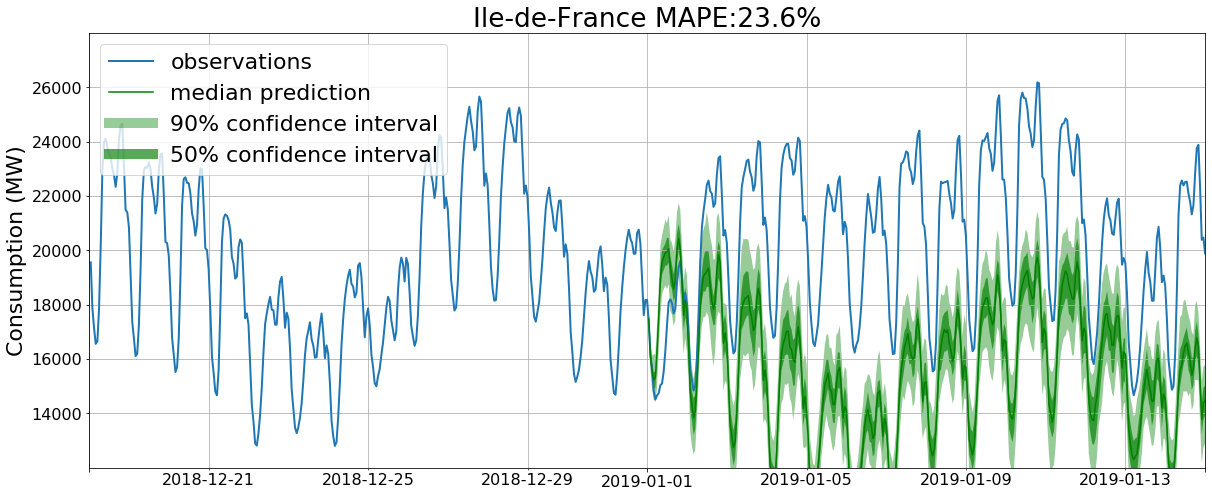

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.22s/it, avg_epoch_loss=11.8]
INFO:root:Epoch[0] Elapsed time 61.168 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=11.759554
INFO:root:Epoch[1] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it, avg_epoch_loss=10.2]
INFO:root:Epoch[1] Elapsed time 54.392 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=10.161926
INFO:root:Epoch[2] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.10s/it, avg_epoch_loss=9.52]
INFO:root:Epoch[2] Elapsed time 54.955 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=9.519468
INFO:root:Epoch[3] Learning rate is 0.0001
100%|█████████████████████████████

INFO:root:Epoch[30] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.10s/it, avg_epoch_loss=7.19]
INFO:root:Epoch[30] Elapsed time 55.054 seconds
INFO:root:Epoch[30] Evaluation metric 'epoch_loss'=7.192022
INFO:root:Epoch[31] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it, avg_epoch_loss=7.19]
INFO:root:Epoch[31] Elapsed time 53.752 seconds
INFO:root:Epoch[31] Evaluation metric 'epoch_loss'=7.194879
INFO:root:Epoch[32] Learning rate is 0.0001
100%|██████████████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it, avg_epoch_loss=7.2]
INFO:root:Epoch[32] Elapsed time 54.203 seconds
INFO:root:Epoch[32] Evaluation metric 'epoch_loss'=7.198212
INFO:root:Epoch[33] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it, avg_epoch_loss=7.18]
INFO:root:Epoch[33] 

100%|█████████████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.01s/it, avg_epoch_loss=6.98]
INFO:root:Epoch[60] Elapsed time 50.402 seconds
INFO:root:Epoch[60] Evaluation metric 'epoch_loss'=6.975160
INFO:root:Epoch[61] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.03s/it, avg_epoch_loss=6.98]
INFO:root:Epoch[61] Elapsed time 51.340 seconds
INFO:root:Epoch[61] Evaluation metric 'epoch_loss'=6.976046
INFO:root:Epoch[62] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.01s/it, avg_epoch_loss=6.97]
INFO:root:Epoch[62] Elapsed time 50.673 seconds
INFO:root:Epoch[62] Evaluation metric 'epoch_loss'=6.972945
INFO:root:Epoch[63] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.00s/it, avg_epoch_loss=6.96]
INFO:root:Epoch[63] Elapsed time 50.030 seconds
INFO:root:Epoch[

100%|█████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it, avg_epoch_loss=6.88]
INFO:root:Epoch[90] Elapsed time 53.657 seconds
INFO:root:Epoch[90] Evaluation metric 'epoch_loss'=6.881595
INFO:root:Epoch[91] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.06s/it, avg_epoch_loss=6.87]
INFO:root:Epoch[91] Elapsed time 53.236 seconds
INFO:root:Epoch[91] Evaluation metric 'epoch_loss'=6.866326
INFO:root:Epoch[92] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.11s/it, avg_epoch_loss=6.85]
INFO:root:Epoch[92] Elapsed time 55.610 seconds
INFO:root:Epoch[92] Evaluation metric 'epoch_loss'=6.852000
INFO:root:Epoch[93] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.13s/it, avg_epoch_loss=6.88]
INFO:root:Epoch[93] Elapsed time 56.283 seconds
INFO:root:Epoch[

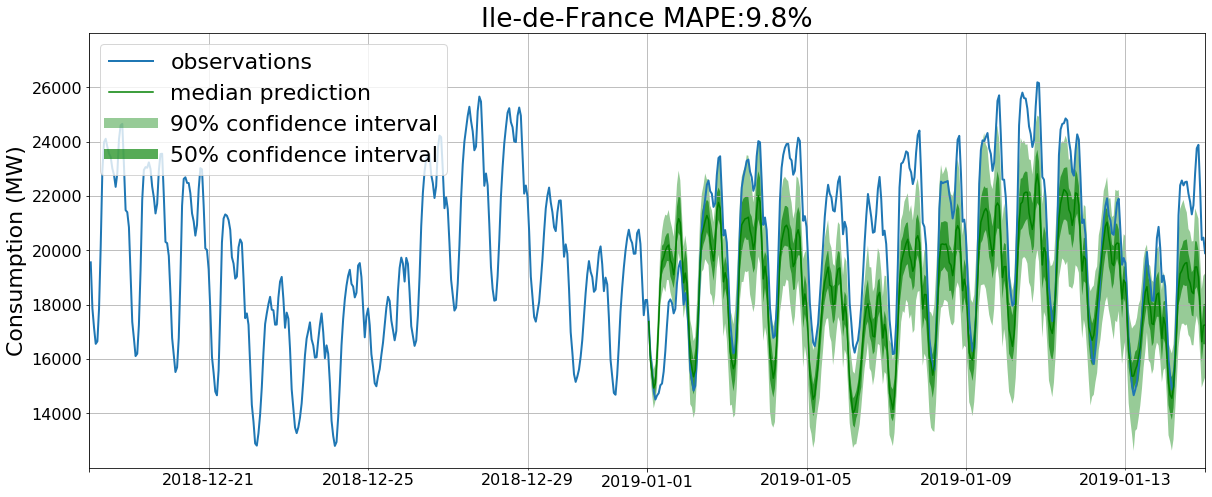

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [01:02<00:00,  1.24s/it, avg_epoch_loss=10.4]
INFO:root:Epoch[0] Elapsed time 62.147 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.357727
INFO:root:Epoch[1] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it, avg_epoch_loss=9.56]
INFO:root:Epoch[1] Elapsed time 53.831 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.555734
INFO:root:Epoch[2] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it, avg_epoch_loss=9.12]
INFO:root:Epoch[2] Elapsed time 53.869 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=9.119475
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████████████████████████

INFO:root:Epoch[30] Learning rate is 0.0001
100%|██████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it, avg_epoch_loss=7.5]
INFO:root:Epoch[30] Elapsed time 53.894 seconds
INFO:root:Epoch[30] Evaluation metric 'epoch_loss'=7.499119
INFO:root:Epoch[31] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.10s/it, avg_epoch_loss=7.51]
INFO:root:Epoch[31] Elapsed time 54.900 seconds
INFO:root:Epoch[31] Evaluation metric 'epoch_loss'=7.511611
INFO:root:Epoch[32] Learning rate is 0.0001
100%|██████████████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.11s/it, avg_epoch_loss=7.5]
INFO:root:Epoch[32] Elapsed time 55.587 seconds
INFO:root:Epoch[32] Evaluation metric 'epoch_loss'=7.498541
INFO:root:Epoch[33] Learning rate is 0.0001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.10s/it, avg_epoch_loss=7.47]
INFO:root:Epoch[33] 

In [ ]:
idf_list = ["Ile-de-France"]

for i in range(10):
    for max_epochs in [100]:
        idf_predictor = train_predictor(df_dict, end_train_date, idf_list, max_epochs=max_epochs,
                                        target_col="Consommation (MW)", feat_dynamic_cols=None)
        
        matplotlib.rcParams.update({'font.size': 22})
        forecasts, tss = make_predictions(idf_predictor, df_dict, test_date, idf_list,
                                          target_col="Consommation (MW)")
        MAPE = plot_forecasts(df_dict, test_date, tss, forecasts, past_length=2*nb_hours_pred, num_plots=1,
                       figname="./deepar_stability_study/figures/{}_epochs_trial_{}.png".format(max_epochs, i+1))
        
        result_df = pd.DataFrame.from_records([{"max_epochs": max_epochs, "MAPE": MAPE, "trial_nb": i+1}])
        
        try:
            existing_results = pd.read_csv("./deepar_stability_study/results.csv")
        except:
            existing_results = None
        
        final_results = pd.concat([existing_results, result_df])
        
        final_results.to_csv("./deepar_stability_study/results.csv", index=False)
        